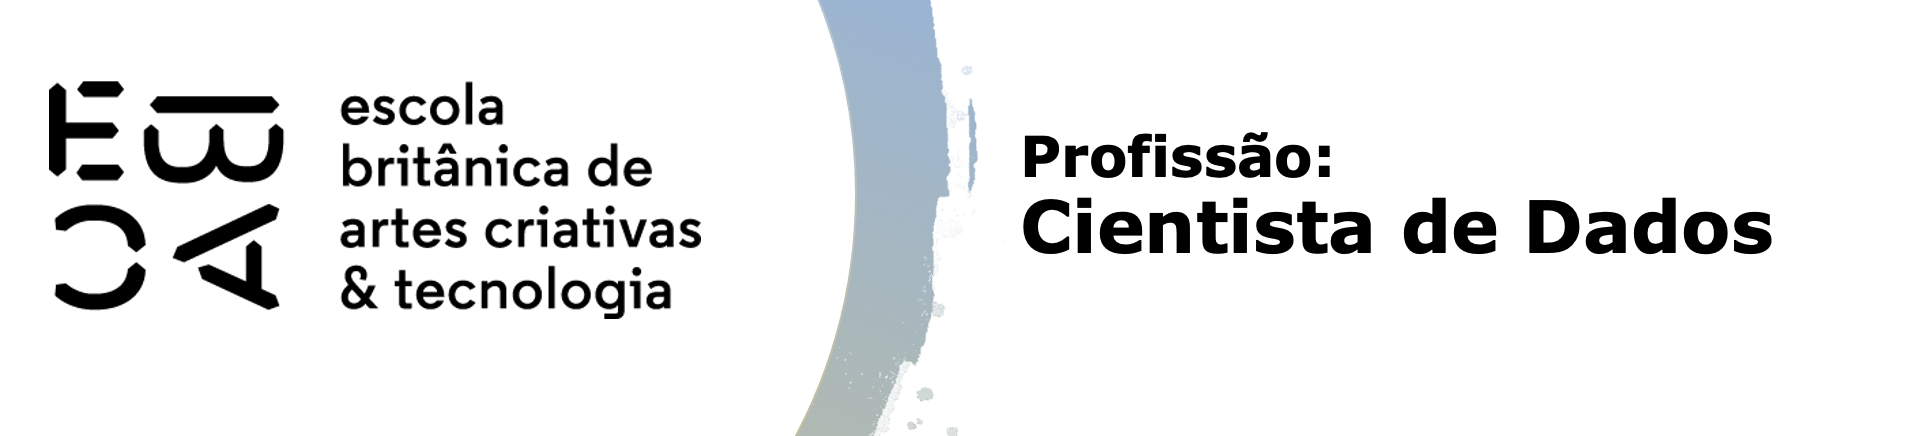

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [6]:
X_train = pd.read_csv('../parte01/output/X_train.csv')
X_test = pd.read_csv('../parte01/output/X_test.csv')
y_train = pd.read_csv('../parte01/output/y_train.csv')
y_test = pd.read_csv('../parte01/output/y_test.csv')

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=100)

### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

In [7]:
%%time
clf = DecisionTreeClassifier(random_state=100, max_depth=4)

clf.fit(X_train, y_train)

importancias = clf.feature_importances_

importancias_df = pd.DataFrame({'Variavel': X_train.columns, 'Importancia': importancias})

importancias_df = importancias_df.sort_values(by='Importancia', ascending=False)

top_3_variaveis = importancias_df.head(3)['Variavel'].tolist()

X_train_top3 = X_train[top_3_variaveis]
X_val_top3 = X_val[top_3_variaveis]
X_test_top3 = X_test[top_3_variaveis]

clf1 = DecisionTreeClassifier(random_state=0, min_samples_leaf=20)
clf1.fit(X_train_top3, y_train)

CPU times: total: 1.59 s
Wall time: 1.64 s


DecisionTreeClassifier(min_samples_leaf=20, random_state=0)

### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [9]:
%%time

path = clf1.cost_complexity_pruning_path(X_train_top3, y_train)
ccp_alphas = path.ccp_alphas

ccp_alphas_reduced = ccp_alphas[::10]

param_grid = {
    'ccp_alpha': ccp_alphas_reduced,
    'min_samples_leaf': [10, 20, 30],
    'max_depth': [None, 5, 10]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_top3, y_train)

CPU times: total: 453 ms
Wall time: 5.23 s


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.00000000e+00, 4.37757182e-05, 1.62028964e-04, 4.23155216e-04,
       5.87184924e-04, 8.48147630e-04, 1.40353351e-03, 2.88685606e-03,
       4.31255693e-02]),
                         'max_depth': [None, 5, 10],
                         'min_samples_leaf': [10, 20, 30]},
             scoring='accuracy')

### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

In [15]:
best_model = DecisionTreeClassifier(random_state=0, **grid_search.best_params_ )

best_model.fit(X_train_top3, y_train)

val_accuracy = best_model.score(X_val_top3, y_val)
val_accuracy

0.8792165397170838

In [16]:
accuracy_test = best_model.score(X_test_top3, y_test)
accuracy_test

0.7265015269765863

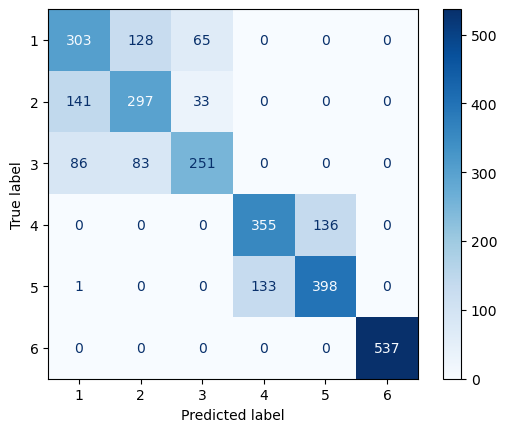

In [19]:
y_pred = best_model.predict(X_test_top3)
mc = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix= mc, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [ ]:
erro_classe_0 = mc[0, 1] / (mc[0, 0] + mc[0, 1])
erro_classe_1 = mc[1, 0] / (mc[1, 0] + mc[1, 1])

classe_maior_erro = 0 if erro_classe_0 > erro_classe_1 else 1

classe_maior_erro

1

In [ ]:
y_train_array = y_train.values if hasattr(y_train, 'values') else y_train
y_pred_train = best_model.predict(X_train_top3)


for i in range(len(y_train_array)):
    if y_train_array[i] == classe_maior_erro and y_pred_train[i] != y_train_array[i]:
        erros_classe_prob[i] = 1

clf_auxiliar = DecisionTreeClassifier(random_state=100, max_depth=4, min_samples_leaf=20)
clf_auxiliar.fit(X_train, erros_classe_prob)

importancias_aux = clf_auxiliar.feature_importances_
importancias_aux_df = pd.DataFrame({'Variavel': X_train.columns, 'Importancia': importancias_aux})
importancias_aux_df = importancias_aux_df.sort_values(by='Importancia', ascending=False)

top_3_novas = importancias_aux_df.head(3)['Variavel'].tolist()
importancias_aux_df.head(10)

,Variavel,Importancia
389,"fBodyAccJerk-bandsEnergy()-1,16",0.234084
421,"fBodyAccJerk-bandsEnergy()-1,24.2",0.210209
503,fBodyAccMag-std(),0.192274
338,"fBodyAcc-bandsEnergy()-1,16.2",0.143374
212,tBodyAccMag-arCoeff()4,0.116034
142,tBodyGyro-entropy()-X,0.041815
104,tBodyAccJerk-entropy()-Z,0.018906
30,"tBodyAcc-arCoeff()-Y,2",0.017315
247,tBodyGyroMag-entropy(),0.013327
411,"fBodyAccJerk-bandsEnergy()-17,24.2",0.010503


In [38]:
vars_combinadas = list(set(top_3_variaveis + top_3_novas))

X_train_novas= X_train[vars_combinadas]
X_val_novas = X_val[vars_combinadas]
X_test_novas = X_test[vars_combinadas]

nova_arvore = DecisionTreeClassifier(random_state=0, **grid_search.best_params_)
nova_arvore.fit(X_train_novas, y_train)


DecisionTreeClassifier(min_samples_leaf=10, random_state=0)

In [39]:
y_val_pred_nova = nova_arvore.predict(X_val_novas)
val_accuracy_nova = accuracy_score(y_val, y_val_pred_nova)

y_test_pred_nova = nova_arvore.predict(X_test_novas)
test_accuracy_nova = accuracy_score(y_test, y_test_pred_nova)

print(f"Acuracia conjunto de validação: {val_accuracy_nova}")
print(f"Acuracia conjunto de teste: {test_accuracy_nova}")

Acuracia conjunto de validação: 0.9227421109902068
Acuracia conjunto de teste: 0.8069222938581608


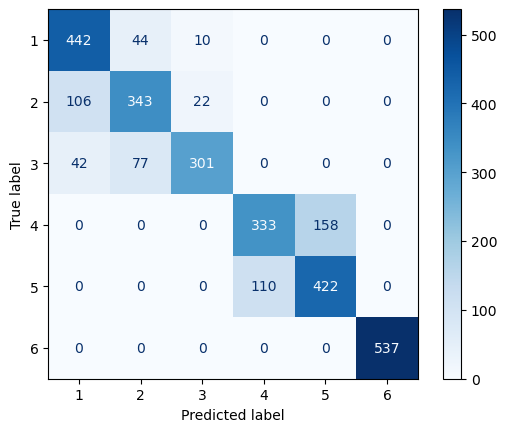

In [40]:
mc_nova = confusion_matrix(y_test, y_test_pred_nova)

disp = ConfusionMatrixDisplay(confusion_matrix= mc_nova, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()